# Part 1: Dataset analysis
##### Description: In this part, we have modified the datasets obtained from the website to improve compatibility with the ML model.
Initially, there were 2 datasets. These are "goodreads_books.json.gz" and "goodreads_interactions.csv". We get this datasets from https://mengtingwan.github.io/data/goodreads.

In [ ]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/goodreads_books.json.gz

In [ ]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/goodreads_interactions.csv

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import gzip
import json
import csv

The dataset "goodreads_books.json.gz" contains book entries. Data such as book's ID, title, url of image, url of webpage, isbn, average_rating, description and etc.

In [2]:
with gzip.open('goodreads_books.json.gz', 'r') as f:
    line = f.readline()

json.loads(line)

{'isbn': '0312853122',
 'text_reviews_count': '1',
 'series': [],
 'country_code': 'US',
 'language_code': '',
 'popular_shelves': [{'count': '3', 'name': 'to-read'},
  {'count': '1', 'name': 'p'},
  {'count': '1', 'name': 'collection'},
  {'count': '1', 'name': 'w-c-fields'},
  {'count': '1', 'name': 'biography'}],
 'asin': '',
 'is_ebook': 'false',
 'average_rating': '4.00',
 'kindle_asin': '',
 'similar_books': [],
 'description': '',
 'format': 'Paperback',
 'link': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'authors': [{'author_id': '604031', 'role': ''}],
 'publisher': "St. Martin's Press",
 'num_pages': '256',
 'publication_day': '1',
 'isbn13': '9780312853129',
 'publication_month': '9',
 'edition_information': '',
 'publication_year': '1984',
 'url': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'image_url': 'https://images.gr-assets.com/books/1310220028m/5333265.jpg',
 'book_id': '5333265',
 'ratings_count': '3',
 'work_id': '5400751',
 'title': '

We created a new dataset called "books_dataset.json.gz" and filled it with data from "goodreads_books.json.gz" to reduce the amount of unusable data.

In [3]:
def parse_field(line):
    data = json.loads(line)
    return [
        data['book_id'],
        data['title'],
        data['url'],
        data['image_url']
    ]

books_dataset = []


with gzip.open('goodreads_books.json.gz', 'r') as f:
    for line in f:
        book_record = parse_field(line)
        books_dataset.append(book_record)

with open('books_dataset.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['book_id', 'title', 'url', 'image_url'])
    writer.writerows(books_dataset)

print("CSV file creation complete.")

CSV file creation complete.


In [4]:
def active_url(val):
    return '<a target="_blank" href="{}">goodreaders</a>'.format(val)

def show_img(val):
    return '<img src="{}" width=50></img>'.format(val)

books_dataset = pd.read_csv('books_dataset.csv')
books_dataset.head(5).style.format({'url': active_url, "image_url": show_img})

,book_id,title,url,image_url
0,5333265,W.C. Fields: A Life on Film,goodreaders,
1,1333909,Good Harbor,goodreaders,
2,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, #1-2)",goodreaders,
3,6066819,Best Friends Forever,goodreaders,
4,287140,Runic Astrology: Starcraft and Timekeeping in the Northern Tradition,goodreaders,


The dataset "goodreads_interactions.csv" contains interactions between users and the books they rated. There are 5 fields. These are user_id, book_id, is_read, rating and is_reviewed. In these fields, we only needed user_id, book_id and rating fields. Also, there were too many records. Therefore, we decided to reduce them.

In [ ]:
goodreads_interactions = pd.read_csv('goodreads_interactions.csv')
goodreads_interactions

In [5]:
goodreads_interactions = pd.read_csv('goodreads_interactions.csv', nrows=1000000)
dataset = goodreads_interactions[['user_id', 'book_id', 'rating']]
dataset.to_csv('dataset.csv', index=False)
dataset

,user_id,book_id,rating
0,0,948,5
1,0,947,5
2,0,946,5
3,0,945,5
4,0,944,5
...,...,...,...
999995,1970,8801,0
999996,1970,18136,0
999997,1970,33163,0
999998,1970,24332,0


# Part 2: Model Analysis
##### Description: In this part, we compare 2 models with each other in order to choose the best one

These models were obtained from websites that are shown below:

https://gilberttanner.com/blog/building-a-book-recommendation-system-usingkeras/ 

https://medium.com/@hamza.emra/introduction-to-recommendation-systems-with-tensorflow-recommenders-a116e5e5a940 

## 2.1 Model from gilberttanner.com
##### Description: This model uses the Keras deep learning library with Embedding layers. An embedding is a mapping from discrete objects, such as words or ids of books in our case, to a vector of continuous values. This can be used to find similarities between the discrete objects that wouldn’t be apparent to the model if it didn’t use embedding layers.

In [6]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
n_users = len(dataset.user_id.unique())
n_books = len(dataset.book_id.unique())

In [7]:
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.compile('adam', 'mean_squared_error')

In [8]:
history = model.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
model.save('model/model.h5')

Epoch 1/5
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 305s 12ms/step - loss: 7.3024
Epoch 2/5
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 300s 12ms/step - loss: 5.1200
Epoch 3/5
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 300s 12ms/step - loss: 4.1788
Epoch 4/5
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 302s 12ms/step - loss: 3.5383
Epoch 5/5
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 304s 12ms/step - loss: 3.0932


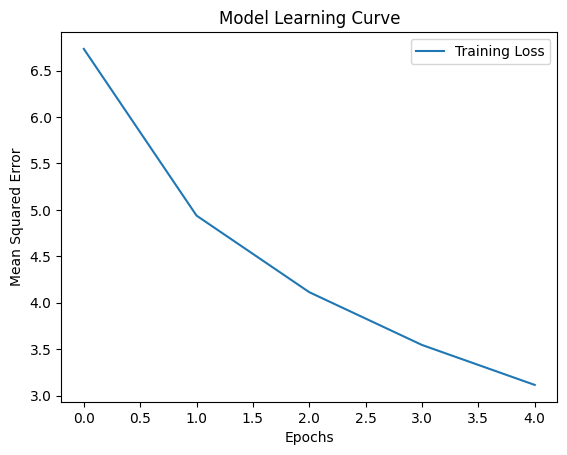

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Then, we can visualize Embeddings. Embeddings can be used to visualize concepts such as the relation of different books in our case:

<Axes: >

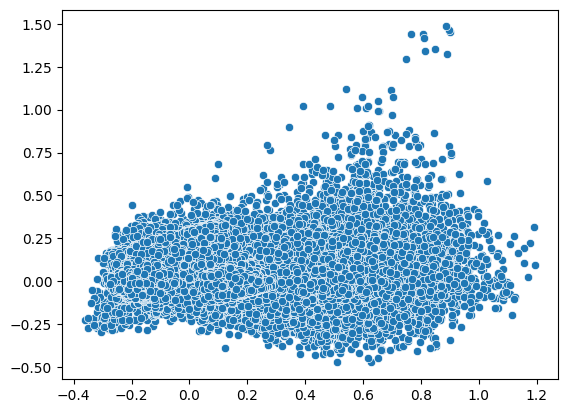

In [10]:
from sklearn.decomposition import PCA
import seaborn as sns


book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

## 2.2 Model from medium.com
##### Description: This model uses the Keras deep learning library and TensorFlow-recommenders library. Also this model is more complex then previus one. Below is a diagram of the model:
<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*xlovSHbecFSDiDPcJq_trQ.png" width="500" height="450">

In [64]:
rating_data = pd.read_csv("datasets/dataset.csv")

rating_data['user_id'] = rating_data['user_id'].astype(str)
rating_data['book_id'] = rating_data['book_id'].astype(str)
rating_data['rating'] = rating_data['rating'].astype(np.float32)

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(rating_data['user_id'].values.reshape(-1, 1), tf.string), 
    tf.cast(rating_data['book_id'].values.reshape(-1, 1), tf.string),
    tf.cast(rating_data['rating'].values.reshape(-1, 1), tf.float32)
))

In [65]:
@tf.function
def rename(x0,x1,x2):
    y = {}
    y["user_id"] = x0
    y["book_id"] = x1
    y["rating"] = x2
    return y

dataset = dataset.map(rename)

In [66]:
books = rating_data.book_id.values
users = rating_data.user_id.values

unique_book_titles = np.unique(list(books))
unique_user_ids = np.unique(list(users))

In [67]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for books.
    self.book_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_book_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_book_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])

  def __call__(self, x):
    
    user_id, book_name = x
    user_embedding = self.user_embeddings(user_id)
    book_embedding = self.book_embeddings(book_name)

    return self.ratings(tf.concat([user_embedding, book_embedding], axis=1))

In [68]:
import tensorflow_recommenders as tfrs

class BooksModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def compute_loss(self, features, training=False) -> tf.Tensor:
    print(features)
    rating_predictions = self.ranking_model((features['user_id'], features["book_id"]))

    return self.task(labels=features["rating"], predictions=rating_predictions)

In [70]:
from datetime import datetime

model = BooksModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cache_dataset = dataset.cache()

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

model.fit(cache_dataset, epochs=5, verbose=1, callbacks=[tensorboard_callback])

Epoch 1/5
{'user_id': <tf.Tensor 'data:0' shape=(1,) dtype=string>, 'book_id': <tf.Tensor 'data_1:0' shape=(1,) dtype=string>, 'rating': <tf.Tensor 'data_2:0' shape=(1,) dtype=float32>}
{'user_id': <tf.Tensor 'data:0' shape=(1,) dtype=string>, 'book_id': <tf.Tensor 'data_1:0' shape=(1,) dtype=string>, 'rating': <tf.Tensor 'data_2:0' shape=(1,) dtype=float32>}
    131/1000000 ━━━━━━━━━━━━━━━━━━━━ 9:33:10 34ms/step - loss: 4.0677 - regularization_loss: 0.0000e+00 - total_loss: 4.0677

KeyboardInterrupt: 

## Conclusion

As you can see in this section, the second model is much more complex then the first. In the training parts, initial losses of the second model are almost two times less than those of the first model. However, training the first model took about 25 minutes while training the second model would take about 48 hours. That's why we decided to choose first model.

# Part 3: Prediction

The model predicts the selected user's rating for each book. Then, we sort the output and get array of indexes. We use this indexes to get book_ids. In this example below, we predict 1st user's ratings, and get top 20 the best books.

In [20]:
dataset = pd.read_csv('dataset.csv')
model = tf.keras.models.load_model('model/model.h5')

book_data = np.array(list(set(dataset.book_id)))
user = np.array([1 for i in range(len(book_data))])
predictions = model.predict([user, book_data])

unique_book_ids = dataset['book_id'].unique()
unique_book_ids.sort()

predictions = np.array([a[0] for a in predictions])
predictions_sorted = (-predictions).argsort()[:20]
recommended_book_ids = np.array([unique_book_ids[a] for a in predictions_sorted])
print(recommended_book_ids)

9462/9462 ━━━━━━━━━━━━━━━━━━━━ 5s 541us/step
[ 68359   7243  23950  34852  23958  27587  46589 127912 100804 108740
  14533  77761  30475  56318  60463  87804  57631  19913  19092    678]


Before showing results of prediction, let's look at favorite books of 1st user:

In [33]:
books_dataset = pd.read_csv('books_dataset.csv')

users_books = dataset[dataset['user_id'] == 1]
users_fav = users_books.sort_values(by='rating', ascending=False)


def active_url(val):
    return '<a target="_blank" href="{}">goodreaders</a>'.format(val)

def show_img(val):
    return '<img src="{}" width=50></img>'.format(val)


users_fav_dataset = books_dataset[books_dataset['book_id'].isin(users_fav['book_id'])]

users_fav_dataset.head(5).style.format({'url': active_url, "image_url": show_img})

,book_id,title,url,image_url
90424,1063,Shibumi,goodreaders,
90427,1064,Shibumi,goodreaders,
185817,1036,Trump: The Way to the Top: The Best Business Advice I Ever Received,goodreaders,
199524,1022,Read My Lips: Sexual Subversion and the End of Gender,goodreaders,
205344,1018,Bodies of Subversion: A Secret History of Women and Tattoo,goodreaders,


As you can see from the execution result below. Not all books are shown. Because more than half of the books in the dataset "dataset.csv" are missing from the dataset "books dataset.csv".

In [22]:
recommended_book_dataset = books_dataset[books_dataset['book_id'].isin(recommended_book_ids)]

recommended_book_dataset.style.format({'url': active_url, "image_url": show_img})

,book_id,title,url,image_url
184423,60463,The Empty House,goodreaders,
330291,19092,Middlemarch,goodreaders,
595845,57631,Sir Gawain and the Green Knight,goodreaders,
983013,7243,Prodigal Son,goodreaders,
1423650,87804,Yes Man,goodreaders,
1481302,108740,Qur'an and Woman: Rereading the Sacred Text from a Woman's Perspective,goodreaders,
1882380,19913,Master of the Moon (Mageverse #2),goodreaders,
2229871,30475,"The Communist Manifesto and Other Revolutionary Writings: Marx, Marat, Paine, Mao, Gandhi, and Others",goodreaders,
2248238,23950,"Trainspotting (Mark Renton, #2)",goodreaders,
